In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path
import glob
import argparse

In [2]:
#https://stackoverflow.com/questions/12299870/computing-x-y-coordinate-3d-from-image-point
#https://github.com/rodolfoap/OpenCV-2Dto3D/blob/master/transform.cpp
#https://www.elsevier.es/en-revista-journal-applied-research-technology-jart-81-articulo-projector-calibration-for-pattern-projection-S1665642314716086?fbclid=IwAR1wAECeNQMEBO-BF8HaAy1AvMraWlumSZ9NeSsTixzpgZJsH0H5O8mL14g

In [3]:
np.set_printoptions(suppress=True)

# Prepare object points for printed chessboard

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# (8,6) is for the given testing images.
# If you use the another data (e.g. pictures you take by your smartphone), 
# you need to set the corresponding numbers.
corner_x = 8
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)
block_len = 2.5
objp = objp * block_len

# Prepare projector image points for projected chessboard

Start finding chessboard corners of depth image...
find the chessboard corners of chessboard/02.png


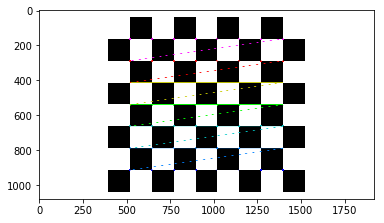

In [5]:
# Arrays to store object points and image points from all the images.
# objpoints = [] # 3d points in real world space
# projected_imgpoints = [] # 2d points in image plane.
chessboard_img_corners = []

pro_img_size = (10, 10)
img_size = (10, 10)

# Make a list of calibration images
images = glob.glob('chessboard/02.png')

# Step through the list and search for chessboard corners
print('Start finding chessboard corners of depth image...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    pro_img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, chessboard_img_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
#         projected_imgpoints.append(chessboard_img_corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), chessboard_img_corners, ret)
        plt.imshow(img)
        


# Known camera intrinsic parameters

In [6]:
RGB_mtx = np.mat([[913.24145912,   0.,         668.9538477  ],
 [  0.,         905.10342204, 389.24919723],
 [  0.,           0.,           1.        ]])

RGB_dist =  np.mat([[ 0.25755514, -0.92817129,  0.00150453,  0.01340316,  1.17293952]])

# Calculate the extrinsic parameters for camera

find the chessboard corners of printed_chessboard\00.png
[[ 6.77064055]
 [ 7.44722681]
 [47.58370732]]

find the chessboard corners of printed_chessboard\02.png
[[ 0.48709533]
 [ 7.17842958]
 [48.40627185]]

find the chessboard corners of printed_chessboard\04.png
[[ 8.69203937]
 [ 7.67678886]
 [45.92036149]]

find the chessboard corners of printed_chessboard\06.png
[[ 7.53920367]
 [ 7.3606731 ]
 [45.14005907]]

find the chessboard corners of printed_chessboard\08.png
[[ 8.96661418]
 [ 7.54234769]
 [43.54343415]]

find the chessboard corners of printed_chessboard\_00.png
[[ 5.10203766]
 [11.47244596]
 [46.47676757]]



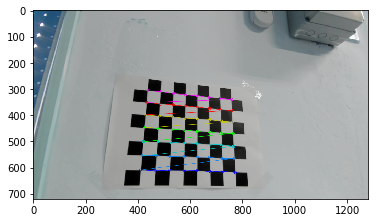

In [7]:
# Calculate the extrinsic parameters using the printed chessboard with the help of the calibrated camera.
T = []
R = []

images = glob.glob('printed_chessboard/*g')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, printed_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), printed_corners, ret)
        plt.imshow(img)
        
        retval, rvec, tvec = cv2.solvePnP(objp, printed_corners, RGB_mtx, RGB_dist)
        T.append(tvec)
        R.append(rvec)
        print(tvec)
        print()
#         print(rvec)
        #tvec rvec store into list

# Calculate the corners of the projected chessboard 
# (with camera's intrinsic and extrinsic matrix and its imagepoints)

In [8]:
from numpy.linalg import inv
def calculate_XYZ(u,v, rotationMatrix, translationVector, cameraMatrix):
    #https://github.com/rodolfoap/OpenCV-2Dto3D/blob/master/transform.cpp                                  
    #Solve: From Image Pixels, find World Points
    Z = 0;
    rotationMatrix,_ = cv2.Rodrigues(rotationMatrix)
    
    uv_1 = np.array([[u,v,1]], dtype=np.float32)
    uv_1 = uv_1.T
    
    invM_x_uv1 = np.matmul(inv(cameraMatrix),uv_1)
    invR_x_invM_x_uv1 = np.matmul(inv(rotationMatrix), invM_x_uv1)
    invR_x_tvec = np.matmul(inv(rotationMatrix), translationVector)
    
    s = (Z + invR_x_tvec[2]) / invR_x_invM_x_uv1[2]
#     print(s,invR_x_invM_x_uv1,invR_x_tvec)
    wcPoint =  s[0,0] * invR_x_invM_x_uv1 - invR_x_tvec

#     print(wcPoint)

    return np.float32(wcPoint.T[0])

In [9]:
# #Test the function (u,v ==> x,y,z=0)
# # print(projected_corners)
# p = calculate_XYZ(printed_corners[0,0,0],printed_corners[0,0,1], R[0], T[0], RGB_mtx)
# print(p)
# # print(objp)

find the chessboard corners of projected_chessboard\01.png
[[ 2.9529417   1.5860149   0.        ]
 [ 5.469831    1.3982809   0.        ]
 [ 8.001192    1.2197567   0.        ]
 [10.363625    1.0414926   0.        ]
 [12.740746    0.8134757   0.        ]
 [15.043292    0.6663367   0.        ]
 [17.276297    0.39463717  0.        ]
 [19.486425    0.27171457  0.        ]
 [ 2.859712    4.0761533   0.        ]
 [ 5.4585743   3.8803494   0.        ]
 [ 7.9786124   3.6417818   0.        ]
 [10.422251    3.4302735   0.        ]
 [12.780385    3.2298477   0.        ]
 [15.157004    2.9784622   0.        ]
 [17.42063     2.780701    0.        ]
 [19.674484    2.5174835   0.        ]
 [ 2.7714357   6.6926146   0.        ]
 [ 5.3963037   6.4122624   0.        ]
 [ 7.9686747   6.15077     0.        ]
 [10.439413    5.898538    0.        ]
 [12.877811    5.6244626   0.        ]
 [15.235327    5.40158     0.        ]
 [17.580774    5.1009626   0.        ]
 [19.817919    4.8786116   0.        ]
 [ 2.

 [19.96727    15.481659    0.        ]]


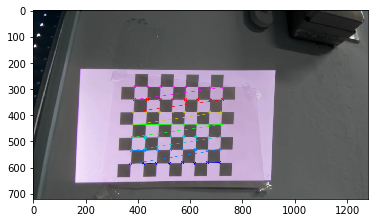

In [10]:
#Calculate the corners of the projected chessboard 
#with the help of the extrinsic and intrinsic parameters of the camera 
#and store in the ‘object points’ matrix.
projected_objpoints = []
projected_imgpoints = []
camera_imgpoints = [] 

# RGB_projected_imgpoints = [] # 2d points in image plane.

projected_obj = np.zeros((56,3), dtype=np.float32)

imgs = glob.glob('projected_chessboard/*g')
for idx, fname in enumerate(imgs):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    #projected_corners in RGB image space
    ret, projected_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        projected_obj = np.zeros((56,3), dtype=np.float32)
        #projected points in RGB image space to would coord
        for i in range(56):
            #對應點找反==>反過來放 55-i 
            projected_obj[i,:] = calculate_XYZ(projected_corners[i,0,0], projected_corners[i,0,1], R[idx], T[idx], RGB_mtx)
            

        print(projected_obj)
        projected_objpoints.append(projected_obj)
        
        projected_imgpoints.append(chessboard_img_corners)
        camera_imgpoints.append(projected_corners)
        
#         print(chessboard_img_corners)
#         print(projected_corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), projected_corners, ret)
        plt.imshow(img)

# print(projected_objpoints)

# Calibration projector

In [11]:
print(len(projected_objpoints), len(projected_imgpoints))
print(pro_img_size)

ret, projector_mtx, projector_dist, projector_rvecs, projector_tvecs = cv2.calibrateCamera(projected_objpoints, projected_imgpoints, pro_img_size,None,None)
projector_Vr = np.array(projector_rvecs)
projector_Tr = np.array(projector_tvecs)
projector_extrinsics = np.concatenate((projector_Vr, projector_Tr), axis=1).reshape(-1,6)

print(ret)
print(projector_mtx)
print(projector_dist)
print()
print(projector_extrinsics)
print(projector_Tr)

# print(projected_objpoints)

6 6
(1920, 1080)
1.8285528918889025
[[2521.16268336    0.         1083.50334751]
 [   0.         2514.23761935  528.77304393]
 [   0.            0.            1.        ]]
[[ -0.68242654  10.11499507  -0.01528482   0.01467357 -64.00723976]]

[[ 0.46577923 -0.54041686 -2.9958099   8.76180164  9.24824491 47.87922878]
 [ 0.71662929 -0.53481487 -2.9151052   2.47222671  9.34710819 48.26741273]
 [ 0.31705901 -0.53648211 -3.00497772 10.68715656  9.39961501 46.36871394]
 [ 0.58694782 -0.53736677 -2.9410292   9.49821767  8.93918918 45.27059636]
 [ 0.31890269 -0.56680722 -3.02653536 10.98373879  8.86911132 44.00008389]
 [ 0.43769015 -0.56355589 -3.03577605  8.82762453  9.02224125 47.12723124]]
[[[ 8.76180164]
  [ 9.24824491]
  [47.87922878]]

 [[ 2.47222671]
  [ 9.34710819]
  [48.26741273]]

 [[10.68715656]
  [ 9.39961501]
  [46.36871394]]

 [[ 9.49821767]
  [ 8.93918918]
  [45.27059636]]

 [[10.98373879]
  [ 8.86911132]
  [44.00008389]]

 [[ 8.82762453]
  [ 9.02224125]
  [47.12723124]]]


# get the last one pair to compute the relationship between camera and projector

In [12]:
#get the last one pair
_projected_objpoints = []
_camera_imgpoints = []
_projected_imgpoints = []

_projected_objpoints.append(projected_objpoints[-1])
_camera_imgpoints.append(camera_imgpoints[-1])
_projected_imgpoints.append(projected_imgpoints[-1])

In [13]:
print('=== Result ===')
ret, projected_int, projected_cam_dist, RGB_cam_int, RGB_cam_dist, depth_rgb_rmat, depth_rgb_tvec, E, F = cv2.stereoCalibrate(
    _projected_objpoints, _projected_imgpoints, _camera_imgpoints, projector_mtx, projector_dist, RGB_mtx, RGB_dist, None)

print('  RMS :', ret)
print('  RGB Camera intrinsic parameters :')
print(RGB_cam_int, '    ')
print('  RGB Camera distortion parameters :')
print(RGB_cam_dist, '    ')
print()
print('  Projector intrinsic parameters :')
print(projected_int, '    ')
print('  Projector distortion parameters :')
print(projected_cam_dist, '    ')
print()
print('  Rotation matrix / translation vector from Projector to RGB camera')
print('  (they translate points from RGB camera coord to Projector coord) :')
print(depth_rgb_rmat, '    ')
print(depth_rgb_tvec, '    ')
print()
print('Rotation vector')
v,_ = cv2.Rodrigues(depth_rgb_rmat)
print(v)

=== Result ===
  RMS : 1.8692166352398458
  RGB Camera intrinsic parameters :
[[913.24145912   0.         668.9538477 ]
 [  0.         905.10342204 389.24919723]
 [  0.           0.           1.        ]]     
  RGB Camera distortion parameters :
[[ 0.25755514 -0.92817129  0.00150453  0.01340316  1.17293952]]     

  Projector intrinsic parameters :
[[2521.16268336    0.         1083.50334751]
 [   0.         2514.23761935  528.77304393]
 [   0.            0.            1.        ]]     
  Projector distortion parameters :
[[ -0.68242654  10.11499507  -0.01528482   0.01467357 -64.00723976]]     

  Rotation matrix / translation vector from Projector to RGB camera
  (they translate points from RGB camera coord to Projector coord) :
[[ 0.99971799 -0.02357489 -0.00285744]
 [ 0.02347024  0.99920105 -0.03234831]
 [ 0.00361776  0.03227212  0.99947257]]     
[[-3.39432142]
 [ 3.75381855]
 [-0.68509662]]     

Rotation vector
[[ 0.03231888]
 [-0.00323847]
 [ 0.02352887]]


In [14]:
# === Result === 0208
#   RMS : 1.8692166352398576
#   RGB Camera intrinsic parameters :
# [[913.24145912   0.         668.9538477 ]
#  [  0.         905.10342204 389.24919723]
#  [  0.           0.           1.        ]]     
#   RGB Camera distortion parameters :
# [[ 0.25755514 -0.92817129  0.00150453  0.01340316  1.17293952]]     

#   Projector intrinsic parameters :
# [[2521.16268336    0.         1083.50334751]
#  [   0.         2514.23761935  528.77304393]
#  [   0.            0.            1.        ]]     
#   Projector distortion parameters :
# [[ -0.68242654  10.11499507  -0.01528482   0.01467357 -64.00723976]]     

#   Rotation matrix / translation vector from RGB camera to Projector
#   (they translate points from Projector coord to RGB camera coord) :
# [[ 0.99971799  0.02347024  0.00361776]
#  [-0.02357488  0.99920105  0.03227212]
#  [-0.00285744 -0.03234831  0.99947257]]     
# [[ 3.30773975]
#  [-3.80873064]
#  [ 0.79646589]]     

# Rotation vector
# [[-0.03231888]
#  [ 0.00323847]
#  [-0.02352887]]

In [15]:
# Result 0207
# Projector intrinsic parameters :
# [[2632.88528666    0.          753.71811534]
#  [   0.         2633.13459721  611.01408057]
#  [   0.            0.            1.        ]]     
#   Projector distortion parameters :
# [[ -0.64789326   5.69455107   0.02388628  -0.00882401 -18.6186877 ]]  

# Rotation matrix / translation vector from RGB camera to Projector
#   (they translate points from RGB camera coord to Projector coord) :
# [[ 0.98172404  0.0298862   0.18794871]
#  [-0.0053981   0.99156793 -0.12947548]
#  [-0.19023345  0.12609463  0.97360741]]   

# [[-0.63573642]
#  [ 2.70586635]
#  [ 2.7919342 ]] 

# Rotation vector
# [[ 0.12892811]
#  [ 0.19078253]
#  [-0.01779997]]


In [16]:
import camera_calibration_show_extrinsics as show

Show the camera extrinsics


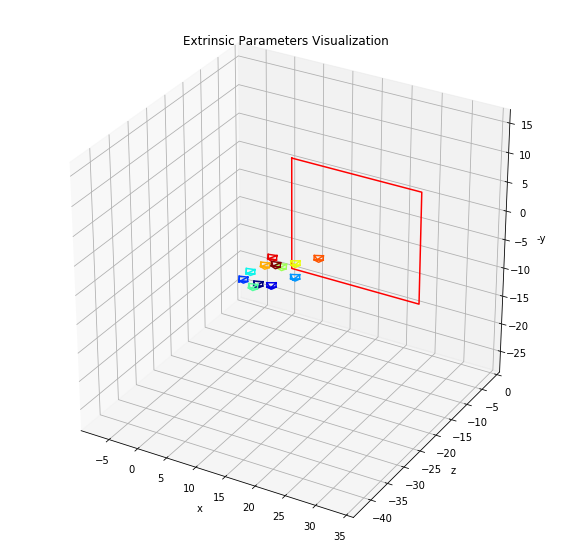

In [17]:
# show the camera extrinsics
print('Show the camera extrinsics')
camera_extrinsics = np.concatenate((R, T), axis=1).reshape(-1,6)
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = RGB_mtx
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 9
board_height = 8
square_size = 2.5

Allextrinsics = np.zeros((camera_extrinsics.shape[0]+projector_extrinsics.shape[0],6))
Allextrinsics[:camera_extrinsics.shape[0]] = camera_extrinsics
Allextrinsics[camera_extrinsics.shape[0]:] = projector_extrinsics

# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, Allextrinsics, board_width,
                                                board_height, square_size, True)

# _min_values, _max_values = show.draw_camera_boards(ax, RGB_cam_int, cam_width, cam_height,
#                                                 scale_focal, RGB_extrinsics, board_width,
#                                                 board_height, square_size, True)

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()